In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing,linear_model
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sys.path.insert(0, '../utils/') 
from readProfiles import *
from pred_models import *
from yellowbrick.model_selection import FeatureImportances

sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
# import umap

##### create single blue colormap to change defualt colors in yellowbrick
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
blue_cmap = cm.get_cmap('Blues', 200)
single_blue_cmap=ListedColormap(blue_cmap(np.linspace(0.7, 0.9, 20)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read treatment level profiles

In [6]:
# procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
# results_dir='./results/'

dataset='LUAD';

################################################
pertColName='PERT'

mergProf_treatLevel,cp_features,l1k_features = \
read_paired_treatment_level_profiles(procProf_dir,dataset,'normalized','highRepOverlap',1)


l1k=mergProf_treatLevel[[pertColName]+l1k_features]
cp=mergProf_treatLevel[[pertColName]+cp_features]

scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp=cp_scaled.copy()
    l1k=l1k_scaled.copy()

/home/ubuntu/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/App1.single_feature_prediction/../utils/readProfiles.py:145: DtypeWarning: Columns (1814) have mixed types.Specify dtype option on import or set low_memory=False.
  [cp_data_repLevel,cp_features], [l1k_data_repLevel,l1k_features] = read_replicate_level_profiles(dataset_rootDir,dataset,profileType,per_plate_normalized_flag);
/home/ubuntu/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/App1.single_feature_prediction/../utils/readProfiles.py:145: DtypeWarning: Columns (1023,1028,1032) have mixed types.Specify dtype option on import or set low_memory=False.
  [cp_data_repLevel,cp_features], [l1k_data_repLevel,l1k_features] = read_replicate_level_profiles(dataset_rootDir,dataset,profileType,per_plate_normalized_flag);


LUAD: Replicate Level Shapes (nSamples x nFeatures): cp:  6144 , 1569 ,  l1k:  4232 , 978
l1k n of rep:  8.0
cp n of rep:  8.0
CP: from  593  to  364
l1k: from  529  to  275
CP and l1k high rep overlap:  197
Treatment Level Shapes (nSamples x nFeatures+metadata): (198, 1570) (198, 979) Merged Profiles Shape: (198, 2548)


In [19]:
# NFE2L2_WT.c
cp_data_repLevel.loc[cp_data_repLevel['x_mutation_status']=='NFE2L2_WT.c','Metadata_Well'].unique()

array(['f16', 'f19', 'm16', 'm21', 'e19', 'm20', 'n15', 'n16'],
      dtype=object)

## For a selected landmark gene, here how we sample images:
- We fit a linear model to treatment level profiles
- We filter the sample to the one that have confident predictions (sample that have l1 norm (true, pred) less than 0.3)
- We samples select highest and lowest prediction values in this filtered set
- We read replicate level profiles
- We randomly select one replicate (pert replicates are at the same well of 8 different plates)
- We select site in the middle of the well (s5 out of 9 available sites)

In [46]:
dataset='LUAD'
profileType='normalized_variable_selected'
per_plate_normalized_flag=1
[cp_data_repLevel,cp_features], [l1k_data_repLevel,l1k_features]=\
read_replicate_level_profiles(procProf_dir,dataset,profileType,per_plate_normalized_flag)

l1k,l1k_features_gn=rename_affyprobe_to_genename(l1k,l1k_features)
#####################################################
dict_imag_lookup={}
# luad_genes_to_inspect_ims=['PRKAG2','BNIP3L','NIPSNAP1','MYO10']
# luad_genes_to_inspect_ims=['ETFB','CISD1','SPP1', 'CDK4', 'S100A4','TSC22D3','MRPL19','TOMM34']
# luad_genes_to_inspect_ims=['NFKBIA','S100A4','S100A13','ETFB','CISD1']
# luad_genes_to_inspect_ims=['HDAC6']
luad_genes_to_inspect_ims=['MLLT11','FAM20B','SQSTM1','TXNRD1']
l1k_2=l1k.copy()
for g in luad_genes_to_inspect_ims:
    model = linear_model.Lasso(alpha=0.02)
    model.fit(cp[cp_features],l1k[g])
    y_pred=model.predict(cp[cp_features])
    l1k_2['pred']=y_pred
    l1k_2['diff']=abs(l1k_2['pred']-l1k[g])
#     l1k_2[l1k_2['diff']<0.3]
    pert_to_vis_max=l1k_2[l1k_2['diff']<0.1].sort_values(by=['pred'],ascending=False)[:10].sample(1).PERT.values[0]
    p,w=cp_data_repLevel[cp_data_repLevel['x_mutation_status']==pert_to_vis_max].sample(1)[['Metadata_Plate','Metadata_Well']].values[0]
    dict_imag_lookup[g]={}
    dict_imag_lookup[g]['high_'+pert_to_vis_max]=[p,w]
    pert_to_vis_min=l1k_2[l1k_2['diff']<0.1].sort_values(by=['pred'],ascending=True)[:10].sample(1).PERT.values[0]
    p,w=cp_data_repLevel[cp_data_repLevel['x_mutation_status']==pert_to_vis_min].sample(1)[['Metadata_Plate','Metadata_Well']].values[0]
    dict_imag_lookup[g]['low_'+pert_to_vis_min]=[p,w]
#     print(g,pert_to_vis_max,pert_to_vis_min)
dict_imag_lookup

/tmp/ipykernel_114940/3953861679.py:5: DtypeWarning: Columns (1023,1028,1032) have mixed types.Specify dtype option on import or set low_memory=False.
  read_replicate_level_profiles(procProf_dir,dataset,profileType,per_plate_normalized_flag)


{'MLLT11': {'high_LAP3_WT.o': [52666, 'j18'],
  'low_TP53_p.N247I': [52666, 'k08']},
 'FAM20B': {'high_TP53_p.G105C': [52674, 'm12'],
  'low_EGFR_p.V769L': [52664, 'i20']},
 'SQSTM1': {'high_RIT1_WT.c': [52671, 'd24'],
  'low_BRAF_p.H574N': [52662, 'c07']},
 'TXNRD1': {'high_FCGR3B_WT.o': [52664, 'j13'],
  'low_TRAP1_WT.o': [52664, 'b03']}}

In [31]:
luad_genes_to_inspect_ims=['MLLT11','FAM20B','SQSTM1','TXNRD1']
l1k_2=l1k.copy()
for g in luad_genes_to_inspect_ims:
    model = linear_model.Lasso(alpha=0.02)
    model.fit(cp[cp_features],l1k[g])
    y_pred=model.predict(cp[cp_features])
    l1k_2['pred']=y_pred
    l1k_2['diff']=abs(l1k_2['pred']-l1k[g])
#     l1k_2[l1k_2['diff']<0.3]
    pert_to_vis_max=l1k_2[l1k_2['diff']<0.3].sort_values(by=['pred'],ascending=False)[:10].PERT.values[0]
    p,w=cp_data_repLevel[cp_data_repLevel['x_mutation_status']==pert_to_vis_max].sample(1)[['Metadata_Plate','Metadata_Well']].values[0]
    dict_imag_lookup[g]={}
    dict_imag_lookup[g]['high_'+pert_to_vis_max]=[p,w]
    pert_to_vis_min=l1k_2[l1k_2['diff']<0.3].sort_values(by=['pred'],ascending=False)[-1:].PERT.values[0]
    p,w=cp_data_repLevel[cp_data_repLevel['x_mutation_status']==pert_to_vis_min].sample(1)[['Metadata_Plate','Metadata_Well']].values[0]
    dict_imag_lookup[g]['low_'+pert_to_vis_min]=[p,w]
#     print(g,pert_to_vis_max,pert_to_vis_min)
dict_imag_lookup

{'MLLT11': {'high_NFE2L2_WT.c': [52674, 'e19'],
  'low_KEAP1_WT.o': [52672, 'd14']},
 'FAM20B': {'high_NFE2L2_WT.c': [52665, 'f19'],
  'low_KEAP1_p.G364C': [52657, 'm10']},
 'SQSTM1': {'high_CASP8_WT.o': [52675, 'p19'],
  'low_KEAP1_p.S144F': [52673, 'd13']},
 'TXNRD1': {'high_STK11_p.D176A': [52664, 'k05'],
  'low_KEAP1_p.S144F': [52653, 'd13']}}

In [45]:
# cp_data_repLevel[cp_data_repLevel['x_mutation_status']==pert_to_vis_max]
# l1k_2[l1k_2['diff']<0.1].sort_values(by=['pred'],ascending=False).PERT.values
# l1k_2[l1k_2['diff']<0.1].sort_values(by=['pred'],ascending=False)[:10].sample(1)
l1k_2[l1k_2['diff']<0.2].sort_values(by=['pred'],ascending=True)

,PERT,AARS1,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10,pred,diff
11,BRAF_p.G466A,-0.254691,-1.749172,1.367887,-0.975027,-0.546793,-1.366567,0.348812,2.737194,-0.304691,...,0.283083,-0.833689,0.000936,-0.513945,0.596781,0.166568,-0.658143,1.045870,-0.822557,0.023987
146,SDHB_WT.o,0.015768,-0.549087,-0.072035,-0.606824,1.290886,0.704896,-0.566782,0.546189,0.208299,...,1.540008,0.275816,-1.245905,0.585443,-1.428664,-0.790965,-1.141487,-0.244285,-0.536796,0.101627
57,FBXW7_p.D101E,-1.689366,0.805477,1.087931,0.188405,-3.256552,1.521065,-1.780716,0.674530,-0.021372,...,-0.396524,0.824180,-0.375596,1.087810,-2.277985,-0.385339,2.381714,0.452154,-0.475192,0.085033
86,KRAS_p.G12C,0.971807,-1.282785,-0.000540,0.620617,-0.211623,-0.788225,-0.889080,-0.394343,-0.214057,...,0.359416,1.200965,-0.663492,-0.145102,-0.038401,-0.778443,-0.597333,-0.246218,-0.439787,0.112955
68,HSD17B10_WT.o,0.156002,0.211041,-1.184638,-1.188039,-0.346639,0.899239,0.616163,0.552755,0.405411,...,-0.204315,-0.617757,-0.340818,-0.271127,-0.452347,-0.400636,-1.358628,-0.680178,-0.390368,0.083377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,ID2_WT.o,-0.881378,-0.161580,-1.215558,-0.137268,0.098172,0.914934,0.898200,-0.004522,0.651550,...,-0.198413,0.473816,-0.402419,-0.269275,0.438227,-0.007005,-0.417849,-0.118120,0.730955,0.153341
169,TP53_p.R248P,1.313696,0.704034,0.987947,0.673490,1.258345,-0.718528,1.201920,-0.904269,-0.116577,...,0.164494,0.294040,2.481438,-0.709273,1.237421,1.386340,-0.899073,-0.629416,0.736399,0.183764
136,RBM10_p.Q416L,1.238174,0.543816,0.892484,1.956773,-0.888357,0.208446,0.487716,-0.405803,-1.715722,...,3.728852,0.293507,1.703221,1.545144,1.635239,0.355401,1.298986,0.021261,0.756946,0.061433
109,NFE2L2_WT.c,-2.851320,2.506023,0.487483,1.689855,0.612411,2.391701,-2.408601,-1.866733,0.214149,...,-1.321279,1.574187,-0.711129,0.519942,-2.531265,-0.580663,-1.172322,-0.566929,0.902679,0.117014


## Run the following on DGX where luad compressed images currently reside

In [ ]:
where2move='/dgx1nas1/storage/data/marziehhaghighi/rosetta_luad_ims/'
luad_im_add='/dgx1nas1/storage/data/jarevalo/luad/dp_project/outputs/compressed/images/'


dict_imag_lookup=\
{'MLLT11': {'high_NFE2L2_WT.c': [52657, 'm21'],'low_RBM45_p.D117N': [52673, 'f10']},
 'FAM20B': {'high_NFE2L2_WT.c': [52663, 'm16'],'low_KEAP1_WT.o': [52653, 'd14']},
 'SQSTM1': {'high_CASP8_WT.o': [52666, 'p19'],'low_ACAA1_WT.o': [52666, 'h20']},
 'TXNRD1': {'high_RBM10_p.Q416L': [52665, 'e01'],'low_BRAF_p.G466A': [52675, 'i17']}}


for g in dict_imag_lookup:
    print(dict_imag_lookup[g])
    geneName=g
    os.system('mkdir '+where2move+g)
    perts_dict=dict_imag_lookup[g].keys()
    for pe in perts_dict:
        os.system('mkdir '+where2move+g+'/'+pe)
        p,w=dict_imag_lookup[g][pe]
        print(p,w)
        plate_path=luad_im_add+str(p)
        list_plate_ims=os.listdir(plate_path)
        random_ims=[l for l in list_plate_ims if ('_'+w+'_' in l) and ('s5' in l)]
        print(random_ims)
#         fgsdfsfd
#         random_im=random.choice(random_ims)
        for r in random_ims:
            command='cp "'+plate_path+'/'+r+'" "'+where2move+g+'/'+pe+'/"'
            os.system(command)

## Check feature importance for a landmark gene of interest

FAM20B


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


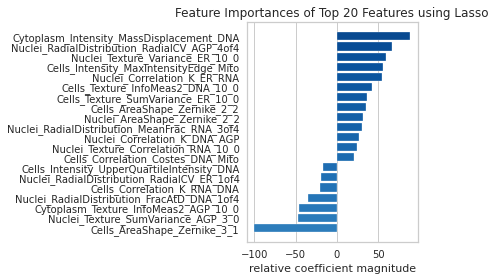

In [23]:
##############################
ge_features_under_test=['FAM20B']

l1k,l1k_features_gn=rename_affyprobe_to_genename(l1k,l1k_features)

for g in ge_features_under_test:
#     viz = FeatureImportances(linear_model.Lasso(),relative=True, topn=20)
#     viz = FeatureImportances(linear_model.Lasso(alpha=0.001), labels=l1k_features_gn, relative=False,topn=20)
    print(g)
#     model = linear_model.LinearRegression()
    model = linear_model.Lasso(alpha=0.02)
    model.fit(cp[cp_features],l1k[g])
# #     model = RandomForestClassifier(n_estimators=10),colormap=single_blue_cmap
#     viz = FeatureImportances(model,topn=20,colormap='coolwarm')    
    viz = FeatureImportances(model,topn=20,colormap=single_blue_cmap)    
    
    viz.fit(cp[cp_features],l1k[g])
    viz.show()

## For the selected list that are in a cluster in figure2d generate images in appendix J

Anne's note:
For the following genes 

I recommend four columns of images where you have the two headings: 
"High levels of gene's mRNA" and 
"Low levels of gene's mRNA" and 
within each you have two columns of images: DNA + RNA (which is w1 and w3). 
Then you have five rows of images for the 6 genes mentioned in the cluster. 
You will want to label each pair of RNA/DNA images with the name of the perturbation. 
You will also want to mention in the legend how you chose those perturbations 
(was it based on measured levels of mRNA or predicted?)

##### Run the following cell on DGX

In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
scalebar = ScaleBar(
    0.656,
    "um",
#     length_fraction=0.25,
    rotation="horizontal",
    scale_loc="right",
    border_pad=1,
    pad=0.5,
    color='w',
    box_color='k',
    location='lower left',
    box_alpha=0,
    fixed_value=20,
    font_properties={"size":10}
)

import matplotlib.pyplot as plt
import cv2
from skimage import exposure
from matplotlib.gridspec import GridSpec

dict_imag_lookup=\
{'MLLT11': {'high_NFE2L2_WT.c': [52657, 'm21'],'low_RBM45_p.D117N': [52673, 'f10']},
 'FAM20B': {'high_NFE2L2_WT.c': [52663, 'm16'],'low_KEAP1_WT.o': [52653, 'd14']},
 'SQSTM1': {'high_CASP8_WT.o': [52666, 'p19'],'low_ACAA1_WT.o': [52666, 'h20']},
 'TXNRD1': {'high_RBM10_p.Q416L': [52665, 'e01'],'low_BRAF_p.G466A': [52675, 'i17']}}

dict_imag_lookup=\
{'MLLT11': {'high_LAP3_WT.o': [52666, 'j18'],'low_TP53_p.N247I': [52666, 'k08']},
 'FAM20B': {'high_TP53_p.G105C': [52674, 'm12'],'low_EGFR_p.V769L': [52664, 'i20']},
 'SQSTM1': {'high_RIT1_WT.c': [52671, 'd24'],'low_BRAF_p.H574N': [52662, 'c07']},
 'TXNRD1': {'high_FCGR3B_WT.o': [52664, 'j13'],'low_TRAP1_WT.o': [52664, 'b03']}}

where2move='/dgx1nas1/storage/data/marziehhaghighi/rosetta_luad_ims/'
luad_im_add='/dgx1nas1/storage/data/jarevalo/luad/dp_project/outputs/compressed/images/'

ch_w_map={'DNA':'w1','ER':'w2','RNA':'w3','AGP':'w4','Mito':'w5'}

channels=['DNA','Mito']

import skimage.io
# f, axarr = plt.subplots(len(dict_imag_lookup), 4,figsize=(15,15));
f = plt.figure(figsize=(15, 12), constrained_layout=False)
# f.subplots_adjust(hspace=0.04, wspace=0)
f.subplots_adjust(hspace=0.04, wspace=0)

gs = GridSpec(len(dict_imag_lookup), 5, figure=f)

gi=0
for g in dict_imag_lookup:
#     print(dict_imag_lookup[g])
#     geneName=g
    perts_dict=dict_imag_lookup[g].keys()
    pei=0
    for pe in perts_dict:
        p,w=dict_imag_lookup[g][pe]
#         print(p,w)
        plate_path=luad_im_add+str(p)
        list_plate_ims=os.listdir(plate_path)
        random_ims=[l for l in list_plate_ims if ('_'+w+'_' in l) and ('s5' in l)]
        random_ims_dna=[l for l in random_ims if (ch_w_map[channels[0]] in l)]
        random_ims_rna=[l for l in random_ims if (ch_w_map[channels[1]] in l)]
        random_ims_dna_rna=random_ims_dna+random_ims_rna
#         print(random_ims_dna_rna)
        ri=0
        for r in random_ims_dna_rna:
            imD0=skimage.io.imread(plate_path+'/'+r)
            imD1=exposure.rescale_intensity(imD0,in_range=(imD0.min(),np.percentile(imD0, 99.95)))
            imD2=imD1[270:810,270:810]
            
            if pei>1:
                ax1 = f.add_subplot(gs[gi,pei+1])
            else:
                ax1 = f.add_subplot(gs[gi,pei])
            
            backtorgb = cv2.cvtColor(imD2,cv2.COLOR_GRAY2RGB)
            if ri==0:
#                 axarr[0,pei].set_title(channels[0],fontsize=12);           
                ax1.set_title(channels[0],fontsize=12);    
                backtorgb[:,:,0]=0.5*backtorgb[:,:,0]
                ax1.set_ylabel('_'.join(pe.split('_')[1:]),fontsize=12);
                ax1.set_ylabel(g+'\n'+ax1.get_ylabel())
            else:
#                 axarr[0,pei].set_title(channels[1],fontsize=12);    
                ax1.set_title(channels[1],fontsize=12); 
                backtorgb[:,:,2]=0.5*backtorgb[:,:,2]

#             R = np.stack((np.zeros(imD2.shape),imD2, imD2), axis=2)
#             axarr[gi,pei].imshow(backtorgb);#axarr[0,cpi].set_title(c,fontsize=18);
#             axarr[gi,pei].xaxis.set_major_locator(plt.NullLocator())
#             axarr[gi,pei].yaxis.set_major_locator(plt.NullLocator())
            ax1.imshow(backtorgb,clim=(0, 255));#axarr[0,cpi].set_title(c,fontsize=18);
            ax1.xaxis.set_major_locator(plt.NullLocator())
            ax1.yaxis.set_major_locator(plt.NullLocator())
            ri+=1
            pei+=1
            
#         axarr[gi,pei-2].set_ylabel('_'.join(pe.split('_')[1:]),fontsize=12);
# #     axarr[gi,0].set_ylabel(g,fontsize=18);
#     axarr[gi,0].set_ylabel(g+'\n'+axarr[gi,0].get_ylabel())

    gi+=1
ax1.add_artist(scalebar);
f.savefig('exd_4.pdf',dpi=600)

# plt.tight_layout()